## 사전 설정

In [2]:
import os
import re
import json
import glob, shutil
import xml.etree.ElementTree as elemTree
from collections import Counter
from itertools import chain
from pathlib import Path
from typing import List, Dict, Union, Tuple, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderConfig,
    VisionEncoderDecoderModel,
    get_scheduler
)
from datasets import Dataset
from datasets import Image as ds_img
from polyleven import levenshtein

2023-08-04 05:03:06.060115: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 05:03:06.758798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 데이터 압축 해제 및 정리

### Download Data

In [18]:
images_path = glob.glob('/home/ubuntu/kr-img2latex/data/synthdog/images/*')
train_json_files = glob.glob('/home/ubuntu/kr-img2latex/data/synthdog/annotations/*')

## Check Samples

In [45]:
sample_img = np.random.choice(images_path)
sample_json = sample_img.replace('images','annotations').replace('.jpg','.json')

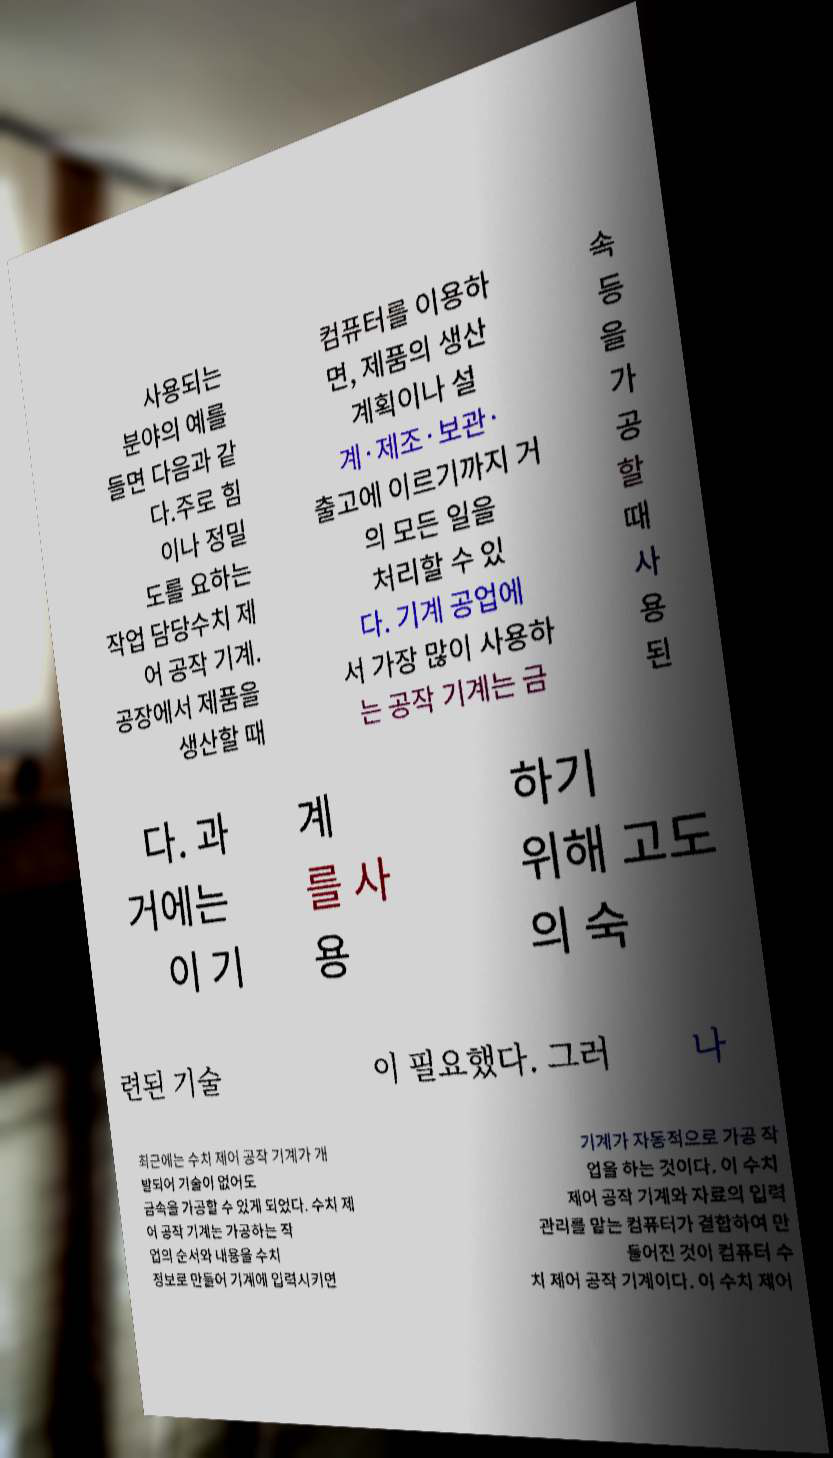

In [46]:
Image.open(sample_img)

In [43]:
with open(Path(sample_json)) as jf:
  temp_json = json.load(jf)

In [22]:
temp_json

{'box': [[0, 0], [107, 0], [107, 21], [0, 21]],
 'type': '텍스트',
 'type_detail': '텍스트',
 'equation': '저장하기 위해 개발되었다. 이는 운동 에너지 가 회전 운동의 형태로 저장된 것이라고 볼 수 있다.어떤 물리적 상황에서 운동 에너지를 수학적으로 기술하는 방법이 몇 가 지 있다. 일상생활에서는 보통 뉴턴 역학에서의 mv 공 식이 가장 적합하다. 하지만 물체 의 속력이 빛의 속력에 가까워지 면 상대론적인 효과가 나타나며 상 대성 이론이 필요하게 된다. 만약 물체가 원자나 아원자 수준의 크기 라면 양자 역학적인 효 과가 두드러 지며 양자 역 학이 필 요하게 된다. 강체의 운동 에너지. 고전 역학'}

In [24]:
temp_json['equation']

'저장하기 위해 개발되었다. 이는 운동 에너지 가 회전 운동의 형태로 저장된 것이라고 볼 수 있다.어떤 물리적 상황에서 운동 에너지를 수학적으로 기술하는 방법이 몇 가 지 있다. 일상생활에서는 보통 뉴턴 역학에서의 mv 공 식이 가장 적합하다. 하지만 물체 의 속력이 빛의 속력에 가까워지 면 상대론적인 효과가 나타나며 상 대성 이론이 필요하게 된다. 만약 물체가 원자나 아원자 수준의 크기 라면 양자 역학적인 효 과가 두드러 지며 양자 역 학이 필 요하게 된다. 강체의 운동 에너지. 고전 역학'

$\int_{-1}^{1}\left|x^{3}-x\right| d x=\int_{-1}^{0}\left(x^{3}-x\right) d x+\int_{0}^{1}\left(-x^{3}+x\right) d x$

$\displaystyle {a_{n+1}}^{2} = a_{n+2} \times a_{n} \to $ 등비수열

$\displaystyle d$ 면

## Config

In [25]:
class CFG:

    # General
    debug = False
    num_proc = 4
    num_workers = 0
    gpus = 1

    # Data
    max_length = 360
    image_height = 480
    image_width = 480

    # Training
    epochs = 3 # 빠른 확인을 위해 1로 설정, 2로 설정하는 것을 추천
    val_check_interval = 1.0  # how many times we want to validate during an epoch
    check_val_every_n_epoch = 1
    gradient_clip_val = 1.0
    lr = 3e-05
    lr_scheduler_type = "linear"
    num_warmup_steps = 100
    seed = 42
    warmup_steps = 300
    output_path = "output"
    log_steps = 200
    batch_size = 1
    use_wandb = False

## Add Special Tokens

In [26]:
PROMPT_TOKEN = "<TPT>"
LINE_LEN_TOKEN_START = "<len>"
LINE_LEN_TOKEN_END = "</len>"
LINE_START = "<line>"
LINE_END = "</line>"
LATEX_START = "<latex>" # $ 가 라텍스 문법을 구분하는 토큰
LATEX_END = "</latex>"
HAND_TOKEN = "<hand>"
PRINT_TOKEN = "<print>"


SEPARATOR_TOKENS = [
    PROMPT_TOKEN,
    LINE_LEN_TOKEN_START,
    LINE_LEN_TOKEN_END,
    LINE_START,
    LINE_END,
    LATEX_START,
    LATEX_END,
    HAND_TOKEN,
    PRINT_TOKEN,
]

new_tokens = SEPARATOR_TOKENS

In [105]:
import random
import string

def generate_random_string(length):
    letters = string.ascii_letters + string.digits
    result_str = ''.join(random.choice(letters) for _ in range(length))
    return result_str

In [115]:
def get_gt_string(filepath: Union[str, os.PathLike]) -> Dict[str, str]:
    """
    Get the ground truth string and x-y data from the given JSON file.

    Args:
        filepath (str): The path to the JSON file

    Returns:
        dict: A dictionary containing the ground truth string, material type, and id
    """
    filepath = Path(filepath)

    with open(filepath, encoding='utf-8') as fp:
        data = json.load(fp)

    data_series = data

    all_lines = []

    NON_OBJECT = False

    for d_line in data_series:
      if 'equation' not in d_line: # 도형, 그래프 제외
        NON_OBJECT = False
        break

      if '$' not in d_line['equation']:
        new_line = LINE_START + d_line['equation'] + LINE_END
      else:
        equation = d_line['equation'].split('$')
        latex_line = equation[0]
        for i, e in enumerate(equation[1:]):
          if i%2 == 0:
            latex_line += LATEX_START + e
          else:
            latex_line += LATEX_END + e

        new_line = LINE_START + latex_line + LINE_END

      all_lines.append(new_line)

    if not NON_OBJECT:
      if data['type_detail'] == '손글씨':
        material_type = HAND_TOKEN
      else:
        material_type = PRINT_TOKEN

      len_of_lines = len(all_lines)
      string_lines = "".join(all_lines)
        
      str = ''
      for _ in range(5):
            random_str = generate_random_string(random.randint(4,12))
            str = str + '-' + random_str

      str = str[1:]

      gt_string = PROMPT_TOKEN + data_series['equation'] + string_lines

      return {
          "ground_truth": gt_string,
          "material_type": data["type_detail"],
          "id": str
      }

    else:
      return False

In [116]:
get_gt_string(sample_json)

{'ground_truth': '<TPT>사용되는 분야의 예를 들면 다음과 같 다.주로 힘 이나 정밀 도를 요하는 작업 담당수치 제 어 공작 기계. 공장에서 제품을 생산할 때 컴퓨터를 이용하 면, 제품의 생산 계획이나 설 계·제조·보관· 출고에 이르기까지 거 의 모든 일을 처리할 수 있 다. 기계 공업에 서 가장 많이 사용하 는 공작 기계는 금 속 등 을 가 공 할 때 사 용 된 다. 과 거에는 이 기 계 를 사 용 하기 위해 고도 의 숙 련된 기술 이 필요했다. 그러 나 최근에는 수치 제어 공작 기계가 개 발되어 기술이 없어도 금속을 가공할 수 있게 되었다. 수치 제 어 공작 기계는 가공하는 작 업의 순서와 내용을 수치 정보로 만들어 기계에 입력시키면 기계가 자동적으로 가공 작 업을 하는 것이다. 이 수치 제어 공작 기계와 자료의 입력 관리를 맡는 컴퓨터가 결합하여 만 들어진 것이 컴퓨터 수 치 제어 공작 기계이다. 이 수치 제어',
 'material_type': '텍스트',
 'id': 'YByt5jxGAqk-cqYyRievCjJ-ZgFtti6mL34-MRDf8-jLoXeE'}

## 데이터셋 구축

In [117]:
def gen_data(files: List[Union[str, os.PathLike]]) -> Dict[str, str]:
    """
    This function takes a list of json files and returns a generator that yields a
    dictionary with the ground truth string and the path to the image.

    Args:
        files (list): A list of json files

    Returns:
        generator: A generator that yields a dictionary with the ground truth string and
            the path to the corresponding image.
    """

    for f in files:

        result = get_gt_string(f)
        if result:
          yield {
              **result,
              "image_path": f.replace('annotations','images').replace('.json','.jpg')
          }


ds = Dataset.from_generator(
    gen_data, gen_kwargs={"files": train_json_files}, num_proc=CFG.num_proc
)

Generating train split: 0 examples [00:00, ? examples/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## 이미지 사이즈 확인

In [118]:
def add_image_sizes(examples: Dict[str, Union[str, os.PathLike]]) -> Dict[str, List[int]]:
    """
    This function takes a dictionary of examples and adds the width and height of the
    image to the dictionary. This is to be used with the `Dataset.map` function.

    Args:
        examples (dict): A dictionary of examples (from `map` function)

    Returns:
        dict: The dictionary with the width and height of the image added
    """

    sizes = [Image.open(x).size for x in examples["image_path"]]

    width, height = list(zip(*sizes))

    return {
        "width": list(width),
        "height": list(height),
    }


ds = ds.map(add_image_sizes, batched=True, num_proc=CFG.num_proc)

Map (num_proc=4):   0%|          | 0/1190 [00:00<?, ? examples/s]

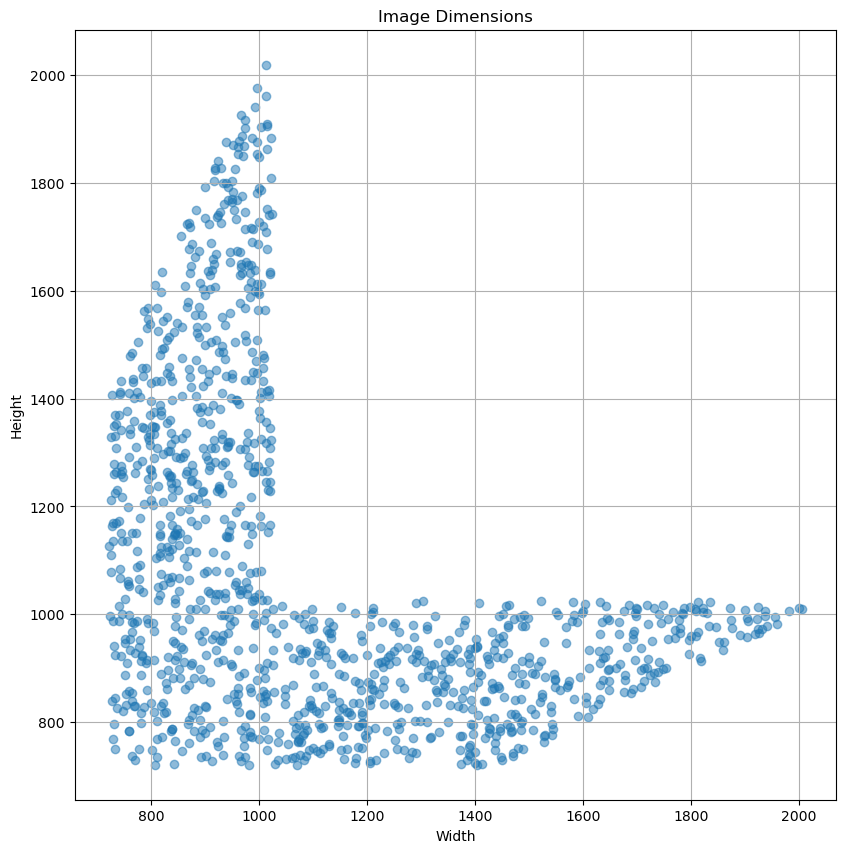

In [119]:
plt.figure(figsize=(10, 10))

plt.scatter(x=ds["width"], y=ds["height"], marker="o", alpha=0.5)

# Add axis labels
plt.xlabel("Width")
plt.ylabel("Height")

# Add a title
plt.title("Image Dimensions")

# Add gridlines
plt.grid(True)

# Set aspect ratio to be equal
plt.gca().set_aspect("equal", adjustable="box")

# Show the plot
plt.show()

## 모델 CONFIG

In [120]:
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = (CFG.image_height, CFG.image_width)
config.decoder.max_length = CFG.max_length

print(CFG.image_height, CFG.image_width, CFG.max_length)

480 480 360


In [121]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.image_processor.size = {
    "height": CFG.image_height,
    "width": CFG.image_width,
}

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## 토크나이징

In [122]:
tree = elemTree.parse('/home/ubuntu/kr-img2latex/vocab/tex_list.xml')
keywords = tree.find('AutoComplete').findall('KeyWord')
math_tokens = ['\\' + x.get('name') for x in keywords]

In [123]:
'\\int' in math_tokens

True

In [124]:
math_tokens[:10]

['\\Alph',
 '\\Alpha',
 '\\AltMacroFont',
 '\\AmSTeX',
 '\\Appendix',
 '\\Arrowvert',
 '\\AtBeginDocument',
 '\\AtEndClass',
 '\\AtEndDocument',
 '\\AtEndOfClass']

### UNK 토큰 핸들링

In [125]:
def check_for_unk(examples: Dict[str, str]) -> Dict[str, List[str]]:
    """
    Check for unknown tokens in the given examples.

    This function takes a dictionary containing a list of ground truth texts and
    tokenizes them using the processor's tokenizer. It then checks for any unknown
    tokens in the tokenized text and returns a dictionary containing a list of the
    unknown tokens for each example.

    Args:
        examples (dict): A dictionary containing a list of ground truth texts.
            Example: {"ground_truth": ["text1", "text2", ...]}

    Returns:
        dict: A dictionary containing a list of unknown tokens for each example.
            Example: {"unk_tokens": [["unk1", "unk2"], [], ["unk3"], ...]}
    """

    texts = examples["ground_truth"]

    ids = processor.tokenizer(texts).input_ids
    tokens = [processor.tokenizer.tokenize(x, add_special_tokens=True) for x in texts]

    unk_tokens = []
    for example_ids, example_tokens in zip(ids, tokens):
        example_unk_tokens = []
        for i in range(len(example_ids)):
            if example_ids[i] == processor.tokenizer.unk_token_id:
                example_unk_tokens.append(example_tokens[i])

        unk_tokens.append(example_unk_tokens)

    return {"unk_tokens": unk_tokens}


unk = ds.map(check_for_unk, batched=True, num_proc=CFG.num_proc)

Map (num_proc=4):   0%|          | 0/1190 [00:00<?, ? examples/s]

In [126]:
# Let's look at only the examples with unknown tokens
unk = unk.filter(lambda x: len(x["unk_tokens"]) > 0, num_proc=CFG.num_proc)

print(len(unk))

unk[0]

Filter (num_proc=4):   0%|          | 0/1190 [00:00<?, ? examples/s]

1006


{'ground_truth': '<TPT>92년부터 이에 따라 한 국음악저작권협회의 신탁을 통해 저작권료를 받고 있었다. 이에 따라 2003 년에 한국음악저작권협 회에서는 프로축구단 경기에서 애국가를 무단으로 사용한 두 구단을 고 소하였으며, 이에 따라 논란이 불거졌다.이후 애국가의 저작권을 국가에 서 사들이는 것에 대한 논 의가 일어났으며, 결국 2005년 3월 16 일 안익태의 유족이 대한민',
 'material_type': '텍스트',
 'id': 'b5o7UQUwoP95-b5ip6My-V2R92gv0FzY-fOcdgLx3Oy1k-kZmPDQ',
 'image_path': '/home/ubuntu/kr-img2latex/data/synthdog/images/image_214.jpg',
 'width': 1004,
 'height': 1081,
 'unk_tokens': ['났']}

In [128]:
all_unk_tokens = [x for y in unk["unk_tokens"] for x in y]

# Counter(all_unk_tokens)

In [129]:
text_unk_tokens = list(set(all_unk_tokens))
text_unk_tokens.remove('1')

In [130]:
# 토큰 추가하기
num_added = processor.tokenizer.add_tokens(["<one>"] + new_tokens + math_tokens + text_unk_tokens)
print(num_added, "tokens added")

2462 tokens added


In [131]:
example_str = "<TPT><hand><len>1</len><line><latex>P(x=x)=\\frac{1}{10}(x-1)(x=1,2,3,4,5)</latex></line>"

temp_ids = processor.tokenizer(example_str).input_ids
print("ids:", temp_ids)
print("tokenized:", processor.tokenizer.tokenize(example_str))
print("decoded:", processor.tokenizer.decode(temp_ids))
print("unk id:", processor.tokenizer.unk_token_id)

ids: [0, 57526, 57533, 57527, 1314, 57528, 57529, 57531, 40769, 7690, 40392, 9026, 40392, 11938, 9026, 58298, 1741, 3, 52613, 32650, 56548, 52613, 7690, 40392, 45391, 43440, 40392, 36966, 35815, 35934, 35815, 52872, 35815, 40711, 57532, 57530, 2]
tokenized: ['<TPT>', '<hand>', '<len>', '▁1', '</len>', '<line>', '<latex>', '▁P', '(', 'x', '=', 'x', ')', '=', '\\frac', '▁{', '1', '}', '{', '10', '}', '(', 'x', '-1', ')(', 'x', '=1', ',', '2', ',', '3,4', ',', '5)', '</latex>', '</line>']
decoded: <s><TPT><hand><len> 1</len><line><latex> P(x=x)=\frac {<unk>}{10}(x-1)(x=1,2,3,4,5)</latex></line></s>
unk id: 3


In [132]:
temp_ids[:10]

[0, 57526, 57533, 57527, 1314, 57528, 57529, 57531, 40769, 7690]

In [133]:
config.pad_token_id = processor.tokenizer.pad_token_id
config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids([PROMPT_TOKEN])[0]
#

In [134]:
import cv2
import numpy as np
from PIL import Image, ImageDraw

def add_random_noise(image, intensity=50):
    """
    Add random noise to a PIL image.
    
    Parameters:
        image (PIL.Image.Image): The input image.
        intensity (int): The intensity of the noise. Higher values result in more noise.
    
    Returns:
        PIL.Image.Image: The image with added noise.
    """
    # Convert the PIL image to a NumPy array
    image_array = np.array(image)

    # Generate random noise
    noise = np.random.randint(-intensity, intensity, size=image_array.shape, dtype=np.int16)

    # Add the noise to the image
    noisy_image_array = np.clip(image_array + noise, 0, 255).astype(np.uint8)

    # Convert the NumPy array back to a PIL image
    noisy_image = Image.fromarray(noisy_image_array)

    return noisy_image
        
def add_random_line_below_handwritten_text(image, text, text_position, line_color=(0, 0, 0), line_thickness=2):
    """
    Add a random horizontal line below handwritten text in a PIL image.

    Parameters:
        image (PIL.Image.Image): The input image.
        text (str): The handwritten text to be placed on the image.
        text_position (tuple): The (x, y) position to place the text.
        line_color (tuple): Color of the horizontal line (default is black).
        line_thickness (int): Thickness of the horizontal line (default is 2).

    Returns:
        PIL.Image.Image: The image with handwritten text and a random line below it.
    """
    # Create a draw object for the image
    draw = ImageDraw.Draw(image)

    # Draw the handwritten text on the image
    draw.text(text_position, text, fill=(0, 0, 0))

    # Generate a random y-coordinate for the line below the text
    line_y = text_position[1] + np.random.randint(20, 50)

    # Draw the random horizontal line below the text
    draw.line([(0, line_y), (image.width, line_y)], fill=line_color, width=line_thickness)

    return image


def add_random_circles(image_pil, num_circles=5, min_radius=10, max_radius=30):
    draw = ImageDraw.Draw(image_pil)

    width, height = image_pil.size

    for _ in range(num_circles):
        x_center, y_center = random.randint(0, width), random.randint(0, height)
        radius = random.randint(min_radius, max_radius)
        color = random.randint(50, 255)

        x1, y1 = x_center - radius, y_center - radius
        x2, y2 = x_center + radius, y_center + radius

        draw.ellipse([(x1, y1), (x2, y2)], outline=color)

    return image_pil

def add_random_scribbles(image_pil, num_scribbles=5, line_thickness=3):
    draw = ImageDraw.Draw(image_pil)

    width, height = image_pil.size

    for _ in range(num_scribbles):
        x1, y1 = random.randint(0, width), random.randint(0, height)
        x2, y2 = random.randint(0, width), random.randint(0, height)
        color = random.randint(50, 255)

        draw.line([(x1, y1), (x2, y2)], fill=color, width=line_thickness)

    return image_pil

## Pixel Value, Input Id 전처리

In [135]:
import torch
import numpy as np
from functools import partial
from typing import Dict, Union, List
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, RandomHorizontalFlip, RandomRotation, RandomResizedCrop
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import random


one_token_id = processor.tokenizer("<one>", add_special_tokens=False).input_ids[0]
unk_token_id = processor.tokenizer.unk_token_id


def replace_unk_one_tokens_with_one(example_ids: List[int], example_tokens: List[str], one_token_id:int, unk_token_id:int) -> List[int]:
    """
    Replace unknown tokens that represent "1" with the correct token id.

    Args:
        example_ids (list): List of token ids for a given example
        example_tokens (list): List of tokens for the same given example
        one_token_id (int): Token id for the "<one>" token
        unk_token_id (int): Token id for the unknown token

    Returns:
        list: The updated list of token ids with the correct token id for "1"
    """

    temp_ids = []
    for id_, token in zip(example_ids, example_tokens):
        if id_ == unk_token_id and token == "1":
            id_ = one_token_id
        temp_ids.append(id_)
    return temp_ids


def preprocess(examples: Dict[str, str], processor: DonutProcessor, CFG: CFG) -> Dict[str, Union[torch.Tensor, List[int], List[str]]]:
    """
    Preprocess the given examples.

    This function processes the input examples by tokenizing the texts, replacing
    any unknown tokens that represent "1" with the correct token id, and loading
    the images.

    Args:
        examples (dict): A dictionary containing ground truth texts, image paths, and ids
        processor: An object responsible for tokenizing texts and processing images
        CFG: A configuration object containing settings and hyperparameters

    Returns:
        dict: A dictionary containing preprocessed images, token ids, and ids
    """

    pixel_values = []

    texts = examples["ground_truth"]

    ids = processor.tokenizer(
        texts,
        add_special_tokens=False,
        max_length=CFG.max_length,
        padding=True,
        truncation=True,
    ).input_ids

    if isinstance(texts, str):
        texts = [texts]

    tokens = [processor.tokenizer.tokenize(text, add_special_tokens=False) for text in texts]

    one_token_id = processor.tokenizer("<one>", add_special_tokens=False).input_ids[0]
    unk_token_id = processor.tokenizer.unk_token_id

    final_ids = [
        replace_unk_one_tokens_with_one(example_ids, example_tokens, one_token_id, unk_token_id)
        for example_ids, example_tokens in zip(ids, tokens)
    ]

    text_position = (10, 350)  # (x, y) position to place the text
    line_color = (0, 0, 0)  # Red color for the line (RGB)
    line_thickness = 3  

    for sample in examples["image_path"]:
        image = sample
        image = sample.convert("RGB").resize((CFG.image_width,CFG.image_height))
        random_number = random.randint(0, 100)
        if random_number <= 15:
            image = RandomRotation(degrees=15)(image)
            image = add_random_noise(image, intensity=50)
            a = random.randint(0, 30)
            b = random.randint(450, 480)
            c = random.randint(50, 80)
            for i in range(a, b, c):
                text_position = (10, i)
                image = add_random_line_below_handwritten_text(image, texts, text_position, line_color, line_thickness)
        elif random_number <= 25:
            image = add_random_circles(image)
        elif random_number <= 35: 
            image = add_random_scribbles(image)
            
        pixel_values.append(processor(image, random_padding=True).pixel_values)

    return {
        "pixel_values": torch.tensor(np.vstack(pixel_values)),
        "input_ids": final_ids,
        "id": examples["id"],
    }


image_ds = ds.cast_column("image_path", ds_img())
image_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

In [136]:
sample = image_ds[[0, 1, 2]]

print(sample["pixel_values"].shape)
print(processor.decode(sample["input_ids"][2]))
print(len(sample["input_ids"][2]))
print(processor.tokenizer.convert_ids_to_tokens(sample["input_ids"][2]))

torch.Size([3, 3, 480, 480])
<TPT> 성의 사례로 평가받 고 있다.위키백과는 자 유 저 작물을 보유하 고 상업적 인 광고가 없으며 주로 기부금 을 통해 지원을 받 는 비영리 단체인 위키미 디어 재단에 의해 소유되고 지 원을 받 고 있다. 202 1년 기준으로 영어 판 약 600만여 개 한 국어판 개를 비롯 하 여 300여 언어판을 합하면 전체 위키백과의 일반 문서(넘 겨주기 와 막다른 문서 제외) 수는 5500만 개 이상이며 한 달 순수 방문자 수는 약 17 억명이다. 위키 백과의 저작권은 크리에이티브 커먼 즈 라이선스(CCL)와 GNU 자유 문서(GFDL)의 2중 라이선스를 따 른다. 두 라이선스 모 두 자유 콘텐츠를 위한 것으로 일정한 요건을 갖추면 사용에 제약을 받 지 않는다.위키 백과 이전에도 온라인 백과사전 을 운영하려는 여러 시도들이 있었으나 실 패하였다. 위키백과 영어 판은 전문가들이 작성 했던 백과사전인 누피디아 에서 비롯 하였다. 누피 디아는 웹 포털 회사인 보미 스가 2000년 3월 9일에 개 시하였다. 보미스의 CE O였던 지미 웨 일스와 편집장 래리 생어는 누피디아의 글들을 오픈 콘텐츠로 제시하기로 하였고 리 처드 스톨 먼이 주도한 GNU 자유
360
['<TPT>', '▁성', '의', '▁사례', '로', '▁평가', '받', '▁고', '▁있다', '.', '위', '키', '백', '과', '는', '▁자', '▁유', '▁저', '▁작', '물을', '▁보', '유', '하', '▁고', '▁상업', '적', '▁인', '▁광고', '가', '▁없', '으며', '▁주로', '▁기', '부', '금', '▁', '을', '▁통해', '▁지원', '을', '▁', '받', '▁', '는', '▁비', '영', '리', '▁단', '체', '인', '▁위', '키', '미', '▁디', '어', '▁', '재단', '에', '▁의해', '▁소', '유', '되고', '▁지', '▁', '원을', '▁', '받

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


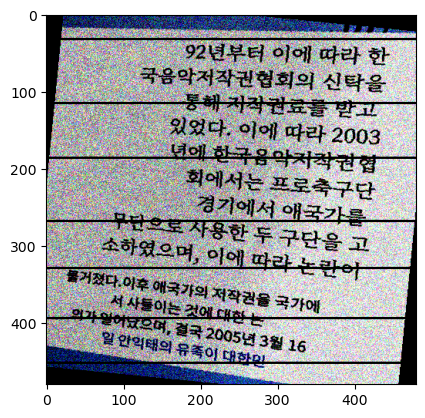

In [137]:
plt.imshow(sample["pixel_values"][0].permute(1,2,0))

## Splits 만들기

In [138]:
# # train_test_split 사용하는 방법
# from sklearn.model_selection import train_test_split

# traIn_ds, val_ds = train_test_split(ds, test_size=0.1, random_state=CFG.seed)

# train_ds = traIn_ds.cast_column("image_path", ds_img())
# train_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

# val_gt_ds = val_ds
# val_ds = val_ds.cast_column("image_path", ds_img())
# val_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

In [139]:
skf = StratifiedKFold(n_splits=80)

fold_idxs = []

for _, val_idxs in skf.split(ds["material_type"], y=ds["material_type"]):
    fold_idxs.append(val_idxs)

In [140]:
fold_idxs

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]),
 array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 array([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104]),
 array([105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119]),
 array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 134]),
 array([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149]),
 array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164]),
 array([165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
        178, 179]),
 array([180, 181, 182,

In [141]:
fold = 0
train_extracted = ds.select(
    list(chain(*[x for i, x in enumerate(fold_idxs) if i != fold]))
)

train_ds = train_extracted.cast_column("image_path", ds_img())
train_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

val_gt_ds = ds.select(fold_idxs[fold])
val_ds = val_gt_ds.cast_column("image_path", ds_img())
val_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

gt_material_type = val_gt_ds["material_type"]
gt_texts = val_gt_ds['ground_truth']
gt_ids = val_gt_ds["id"]

i = 0
print(gt_material_type[i])
print(gt_texts[i])
print(gt_ids[i])
print(Counter(gt_material_type))

텍스트
<TPT>92년부터 이에 따라 한 국음악저작권협회의 신탁을 통해 저작권료를 받고 있었다. 이에 따라 2003 년에 한국음악저작권협 회에서는 프로축구단 경기에서 애국가를 무단으로 사용한 두 구단을 고 소하였으며, 이에 따라 논란이 불거졌다.이후 애국가의 저작권을 국가에 서 사들이는 것에 대한 논 의가 일어났으며, 결국 2005년 3월 16 일 안익태의 유족이 대한민
b5o7UQUwoP95-b5ip6My-V2R92gv0FzY-fOcdgLx3Oy1k-kZmPDQ
Counter({'텍스트': 15})


## `ids` 가 batch 마다 전부 같은 길이를 가지도록 하는 collate function

In [142]:
pad_token_id = processor.tokenizer.pad_token_id


def collate_fn(samples: List[Dict[str, Union[torch.Tensor, List[int], str]]]) -> Dict[str, Union[torch.Tensor, List[str]]]:
    """
    Custom collate function for DataLoader.

    This function takes a list of samples and combines them into a batch with
    properly padded input_ids.

    Args:
        samples (List[Dict[str, Union[torch.Tensor, List[int], str]]]):
            A list of samples, where each sample is a dictionary containing
            "pixel_values" (torch.Tensor), "input_ids" (List[int]), and "id" (str).

    Returns:
        Dict[str, Union[torch.Tensor, List[str]]]:
            A dictionary containing the combined pixel values, padded input_ids, and ids.
    """

    batch = {}

    batch["pixel_values"] = torch.stack([x["pixel_values"] for x in samples])

    max_length = max([len(x["input_ids"]) for x in samples])

    # Make a multiple of 8 to efficiently use the tensor cores
    if max_length % 8 != 0:
        max_length = (max_length // 8 + 1) * 8

    input_ids = [
        x["input_ids"] + [pad_token_id] * (max_length - len(x["input_ids"]))
        for x in samples
    ]

    labels = torch.tensor(input_ids)
    labels[labels == pad_token_id] = -100 # ignore loss on padding tokens
    batch["labels"] = labels

    batch["id"] = [x["id"] for x in samples]

    return batch

## Dataloaders

- Validation은 generation을 사용하기 때문에 굉장히 느리다.
- 따라서 sample의 일부를 적게만 사용한다.

In [143]:
if CFG.debug:
    train_ds = train_ds.select(range(100))
    val_ds = val_ds.select(range(100))

train_dataloader = DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)
val_dataloader = DataLoader(
    val_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)

num_training_steps = len(train_dataloader) * CFG.epochs // CFG.gpus

batch = next(iter(train_dataloader))

batch.keys(), [(k, v.shape) for k, v in batch.items() if k != "id"]

(dict_keys(['pixel_values', 'labels', 'id']),
 [('pixel_values', torch.Size([1, 3, 480, 480])),
  ('labels', torch.Size([1, 248]))])

In [144]:
batch['pixel_values'][0]

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [ 0.3882,  0.3804,  0.3725,  ...,  0.6549,  0.6549,  0.6549],
         [ 0.3725,  0.3647,  0.3569,  ...,  0.6627,  0.6706,  0.6706],
         [ 0.3647,  0.3569,  0.3490,  ...,  0.6706,  0.6784,  0.6863]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [ 0.2627,  0.2549,  0.2471,  ...,  0.5137,  0.5137,  0.5137],
         [ 0.2471,  0.2392,  0.2314,  ...,  0.5216,  0.5294,  0.5294],
         [ 0.2392,  0.2314,  0.2235,  ...,  0.5294,  0.5373,  0.5451]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


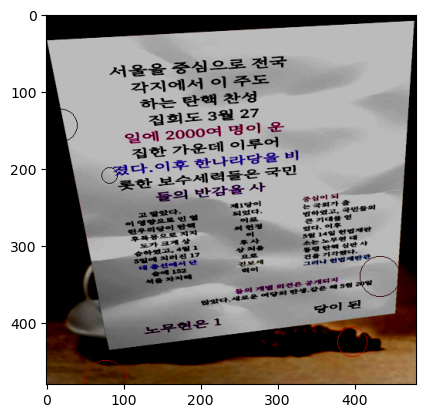

In [145]:
plt.imshow(batch['pixel_values'][0].permute(1,2,0))

In [146]:
batch['labels'][0]

tensor([57526, 23654, 39987,  1644, 15234, 47815, 34917,  4767,  4529, 12002,
        45656,  1234,  2083, 42990, 39292, 53655, 42990, 48107, 36876, 27962,
        46790,  1234,  9066, 38768, 10558, 42990, 56389, 37999, 52673, 42990,
        47021, 46593, 27962, 57303, 49332, 12002, 10648, 25672, 42990, 43050,
        39539, 41915, 17037, 36215, 37703, 37485, 51140, 39987, 49495, 42990,
        59901, 36215, 45559, 26749, 45421, 12058, 18132, 42487, 42990, 17929,
        22880, 55699, 45993, 46473, 56159, 40982, 39539, 12002, 28688, 28441,
        15234, 54198, 15518, 42990, 14762, 54376, 51140, 41915, 42990, 39292,
        53655, 55991, 54810, 47874, 15234, 47223,  4767,  5927, 49591, 55904,
         2665, 48383, 52084,  1972, 35815, 22081, 38768,  1314, 20017, 56389,
        37551, 50983, 39649, 50090, 46348, 27642, 43151,  4529,  9079, 42990,
        59809, 35463, 48237, 56119, 39987, 17034,  4767, 21376, 48018, 57525,
        51140, 41915, 55589, 39539, 12002,  2125, 42990, 14983, 

## Metric을 계산하기 위한 function

In [147]:
def rmse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the Root Mean Square Error (RMSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The Root Mean Square Error.
    """
    return np.sqrt(np.mean(np.square(np.subtract(y_true, y_pred))))


def sigmoid(x: float) -> float:
    """
    Calculate the sigmoid function for the given value.

    Args:
        x (float): The input value.

    Returns:
        float: The result of the sigmoid function.
    """
    return 2 - 2 / (1 + np.exp(-x))


def normalized_rmse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the normalized Root Mean Square Error (RMSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The normalized Root Mean Square Error.
    """
    numerator = rmse(y_true, y_pred)
    denominator = rmse(y_true, np.mean(y_true))

    if denominator == 0:
        if numerator == 0:
            return 1.0
        return 0.0

    return sigmoid(numerator / denominator)


def normalized_levenshtein_score(y_true: List[str], y_pred: List[str]) -> float:
    """
    Calculate the normalized Levenshtein distance between two lists of strings.

    Args:
        y_true (List[str]): The true values.
        y_pred (List[str]): The predicted values.

    Returns:
        float: The normalized Levenshtein distance.
    """
    total_distance = np.sum([levenshtein(yt, yp) for yt, yp in zip(y_true, y_pred)])
    length_sum = np.sum([len(yt) for yt in y_true])
    return sigmoid(total_distance / length_sum)

def score_series(
    y_true: List[Union[float, str]], y_pred: List[Union[float, str]]
) -> float:
    """
    Calculate the score for a series of true and predicted values.

    Args:
        y_true (List[Union[float, str]]): The true values.
        y_pred (List[Union[float, str]]): The predicted values.

    Returns:
        float: The score for the series.
    """
    if len(y_true) != len(y_pred):
        pass
        #return 0.0
    if isinstance(y_true[0], str):
        return f1_score(y_true, y_pred)
    else:
        # Since this is a generative model, there is a chance it doesn't produce a float.
        # In that case, we return 0.0.
        try:
            return mse(list(map(float, y_true)), list(map(float, y_pred)))
            # return normalized_rmse(y_true, list(map(float, y_pred)))
        except:
            return 0.0


def benetech_score(ground_truth: pd.DataFrame, predictions: pd.DataFrame) -> float:
    """Evaluate predictions using the metric from the Benetech - Making Graphs Accessible.

    Parameters
    ----------
    ground_truth: pd.DataFrame
        Has columns `[data_series, chart_type]` and an index `id`. Values in `data_series`
        should be either arrays of floats or arrays of strings.

    predictions: pd.DataFrame
    """
    if not ground_truth.index.equals(predictions.index):
        raise ValueError(
            "Must have exactly one prediction for each ground-truth instance."
        )
    if not ground_truth.columns.equals(predictions.columns):
        raise ValueError(f"Predictions must have columns: {ground_truth.columns}.")
    pairs = zip(
        ground_truth.itertuples(index=False), predictions.itertuples(index=False)
    )
    scores = []
    for (gt_series, gt_type), (pred_series, pred_type) in pairs:
        # if gt_type != pred_type:  # Check material_type condition
        #     scores.append(0.0)
        # else:  # Score with RMSE or Levenshtein as appropriate
        scores.append(score_series(gt_series, pred_series))

    ground_truth["score"] = scores

    grouped = ground_truth.groupby("material_type", as_index=False)["score"].mean()

    material_type2score = {
        material_type: score
        for material_type, score in zip(grouped["material_type"], grouped["score"])
    }

    return np.mean(scores), material_type2score

def f1_score(y_true: List[str], y_pred: List[str]) -> float:
    """
    Calculate the F1 score between the true and predicted values.

    Args:
        y_true (List[str]): The true values.
        y_pred (List[str]): The predicted values.

    Returns:
        float: The F1 score.
    """
    true_set = set(y_true)
    pred_set = set(y_pred)
    intersection = true_set.intersection(pred_set)
    precision = len(intersection) / len(pred_set) if len(pred_set) > 0 else 0.0
    recall = len(intersection) / len(true_set) if len(true_set) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return f1

def mse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the Mean Squared Error (MSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The Mean Squared Error.
    """
    return np.mean(np.square(np.subtract(y_true, y_pred)))

def string2doublet(pred_string: str) -> Tuple[str, List[str]]:
    """
    Convert a prediction string to a doublet of material type, and text.

    Args:
        pred_string (str): The prediction string.

    Returns:
        Tuple[str, List[str]]: A doublet of material type, and text.
    """

    material_type = "인쇄체"
    for tok in [HAND_TOKEN, PRINT_TOKEN]:
        if tok in pred_string:
            if tok == HAND_TOKEN:
                material_type = '손글씨'
            else:
                material_type = '인쇄체'

    pred_string = re.sub(r"<one>", "1", pred_string)

    text = pred_string

    if len(text) == 0:
        return material_type, []

    return material_type, text


def validation_metrics(val_outputs: List[str], val_ids: List[str], gt_df: pd.DataFrame) -> Dict[str, float]:
    """
    Calculate validation metrics for a set of outputs, ids, and ground truth dataframe.

    Args:
        val_outputs (List[str]): A list of validation outputs.
        val_ids (List[str]): A list of validation ids.
        gt_df (pd.DataFrame): The ground truth dataframe.

    Returns:
        Dict[str, float]: A dictionary containing the validation scores.
    """
    pred_doublets = []

    for example_output in val_outputs:
        pred_doublets.append(string2doublet(example_output))

    # Comment[전현욱] : 생각해보니 굳이 material type 별로 점수를 나눌 필요가 있을까 싶다
    pred_df = pd.DataFrame(
        index=val_ids,
        data={
            "text": [x[1] for x in pred_doublets],
            "material_type": [x[0] for x in pred_doublets],
        },
    )

    overall_score, material_type2score = benetech_score(
        gt_df.loc[pred_df.index.values], pred_df
    )

    return {
        "val_score": overall_score,
        **{f"{k}_score": v for k, v in material_type2score.items()},
    }

## Lightning Module

In [148]:
import pytorch_lightning as pl
import gc
from transformers import PreTrainedTokenizerBase, PreTrainedModel

class DonutModelPLModule(pl.LightningModule):
    def __init__(self, processor: PreTrainedTokenizerBase, model: PreTrainedModel, gt_df: pd.DataFrame, num_training_steps: int):
        """
        A PyTorch Lightning module for the DonutModel.

        Args:
            processor (PreTrainedTokenizerBase): The tokenizer/processor for the model.
            model (PreTrainedModel): The pretrained model.
            gt_df (pd.DataFrame): The ground truth dataframe.
            num_training_steps (int): The number of training steps.
        """
        super().__init__()
        self.processor = processor
        self.model = model
        self.gt_df = gt_df
        self.num_training_steps = num_training_steps

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        gc.collect()
        torch.cuda.empty_cache()

        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int, dataset_idx: int = 0) -> None:
        pixel_values = batch["pixel_values"]
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full(
            (batch_size, 1),
            self.model.config.decoder_start_token_id,
            device=self.device,
        )

        outputs = self.model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=CFG.max_length,
            early_stopping=True,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

        self.val_outputs.extend(
            self.processor.tokenizer.batch_decode(outputs.sequences)
        )
        self.val_ids.extend(batch["id"])

    def on_validation_start(self) -> None:
        gc.collect()
        torch.cuda.empty_cache()

        self.val_outputs, self.val_ids = [], []

    def on_validation_epoch_end(self) -> None:

        metrics = validation_metrics(self.val_outputs, self.val_ids, self.gt_df)
        print("\n", metrics)

        self.log_dict(metrics)

        self.val_outputs, self.val_ids = [], []

    def configure_optimizers(self) -> torch.optim.Optimizer:

        optimizer = torch.optim.Adam(self.parameters(), lr=CFG.lr, betas=(0.9, 0.999), eps=1e-08)
        scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
        
        return optimizer

### Model, Ground Truth DataFrame 생성

In [149]:
gt_material_type = val_gt_ds["material_type"]
gt_texts = val_gt_ds["ground_truth"]
gt_ids = val_gt_ds["id"]

gt_df = pd.DataFrame(
    index=gt_ids,
    data={
        "text": gt_texts,
        "material_type": gt_material_type,
    },
)


model = VisionEncoderDecoderModel.from_pretrained(
    "naver-clova-ix/donut-base", config=config, ignore_mismatched_sizes=True
)
model.decoder.resize_token_embeddings(len(processor.tokenizer))
model_module = DonutModelPLModule(processor, model, gt_df, num_training_steps)

In [150]:
# Check if it works
outputs = model(batch["pixel_values"], labels=batch["labels"])

In [152]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

checkpoint_cb = ModelCheckpoint(CFG.output_path)

loggers = []

trainer = pl.Trainer(
        accelerator="gpu",
        devices=CFG.gpus,
        max_epochs=CFG.epochs,
        val_check_interval=CFG.val_check_interval,
        check_val_every_n_epoch=CFG.check_val_every_n_epoch,
        gradient_clip_val=CFG.gradient_clip_val,
        precision=16, # if you have tensor cores (t4, v100, a100, etc.) training will be 2x faster
        num_sanity_val_steps=5,
        callbacks=[checkpoint_cb],
        logger=loggers
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [46]:
torch.set_float32_matmul_precision('high')

In [154]:
trainer.fit(model_module, train_dataloaders=train_dataloader)

/home/ubuntu/.conda/envs/team_conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 204 M 
----------------------------------------------------
204 M     Trainable params
0         Non-trainable params
204 M     Total params
817.492   Total estimated model params size (MB)
/home/ubuntu/.conda/envs/team_conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve p

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [155]:
trainer.validate(model_module, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/.conda/envs/team_conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]


 {'val_score': 0.6954706628854719, '텍스트_score': 0.6954706628854719}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_score           0.6954706628854719
        텍스트_score           0.6954706907272339
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_score': 0.6954706628854719, '텍스트_score': 0.6954706907272339}]

In [156]:
# check gt label
for i, batch in enumerate(val_dataloader):
  if i == 10:
    break
  for b in batch['labels']:
    tokens = []
    for token in b:
      if token != -100:
        tokens.append(token)
    print(processor.decode(tokens))

<TPT> 92년부터 이에 따 라 한 국음악저작권협회의 신탁을 통해 저작권료를 받 고 있었다. 이에 따 라 2003 년에 한국음악저작권협 회에서는 프로축구단 경기에서 애국가를 무단으로 사용한 두 구단을 고 소하였으며, 이에 따 라 논 란이 불거졌다.이후 애국가의 저작권을 국가에 서 사들이는 것에 대한 논 의가 일어났 으며, 결국 2005년 3월 16 일 안익태의 유족이 대한민
<TPT> 한다.이제 formul a_24을 차원의 방정식이라 하면 그 근인 y<one> y2...... y에 는 i가 존재하여 야 하므로 식 (1) 에 따 라 다 음과 같 이 나 타낼 수 있다.그런데 이러한 관계 를 만족하는 대수방 정식의 근이 유리 수라고 가정 하면 무 한히 약 분할 수 있어서, 이를 기약분수로 표현 할 수 없는 모순이 생긴다. 유리수를 기 약분수로 표현할 수 없다는 것은 유리수의 정의에 어긋나므로 가 정계수 대수방정 식 formula_20의 근이라는 최 초의 가정 이 잘못되 었다고 볼 수밖 에 없다. 즉, 원주율은 초월수이다. 자세한 증명은 링크한 주석을 참 고하기 바란다.개 요에서 밝 혔듯이 원
<TPT> 성의 사례로 평가받 고 있다.위키백과는 자 유 저 작물을 보유하 고 상업적 인 광고가 없으며 주로 기부금 을 통해 지원을 받 는 비영리 단체인 위키미 디어 재단에 의해 소유되고 지 원을 받 고 있다. 202 1년 기준으로 영어 판 약 600만여 개 한 국어판 개를 비롯 하 여 300여 언어판을 합하면 전체 위키백과의 일반 문서(넘 겨주기 와 막다른 문서 제외) 수는 5500만 개 이상이며 한 달 순수 방문자 수는 약 17 억명이다. 위키 백과의 저작권은 크리에이티브 커먼 즈 라이선스(CCL)와 GNU 자유 문서(GFDL)의 2중 라이선스를 따 른다. 두 라이선스 모 두 자유 콘텐츠를 위한 것으로 일정한 요건을 갖추면 사용에 제약을 받 지 않는다.위키 백과 이전에도 온라인 백과사전 을 운영하려는 여러 시도들이 있었으나 실 패하였다. 위키백과 영어 판은 전문가들이 작

## Test

In [172]:
test_img_paths= glob.glob('/home/ubuntu/kr-img2latex/data/synthdog/images/*')
sample_test_img_path = np.random.choice(test_img_paths)
sample_test_json_file = sample_img.replace('images','annotations').replace('.jpg','.json')

In [173]:
# for personal data
# sample_test_img_path = '/content/mypic.jpg'

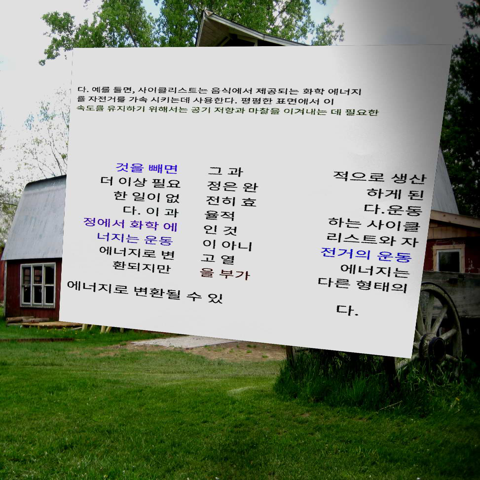

In [174]:
sample_test_img = Image.open(sample_test_img_path).convert("RGB").resize((CFG.image_width, CFG.image_height))
sample_test_img

In [175]:
pixel_values = processor(sample_test_img, random_padding=True).pixel_values
pixel_values = torch.FloatTensor(pixel_values).to('cuda')

decoder_input_ids = torch.full(
            (1, 1),
            model.config.decoder_start_token_id,
            device='cuda',
)

model.cuda()

outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=CFG.max_length,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
)

In [176]:
processor.tokenizer.batch_decode(outputs.sequences)

['<TPT><TPT> 다. 예를 들어, 사이클리스트는 음석이서 체결되는 화학 에너지 를 설명할 수 있는데 사용된다. 말한 표현에서 이 이 러가지로 사용된다. 덧셈 에너지는 덧셈 은 곱셈 에너지로 내 각의 속도 를 따 라서는 정의한 덧셈 에너지로 내 각의 속도가 아닌 정의한 덧셈 에너지로 내 각각의 속도가 아닌 정의한 곱셈 에너지로 내각 을 따 라서 는 정의한 곱셈 에너지로 변환될 수 있 은 완 전히 효 리적 효 리적 히 고 같 이 아니 는 같 이 아니라 는 곱셈 에너지로 변환될 수 있 는 원 리를 따 라 쓰 이는 곱셈 에너지는 다른 형태의 다. 따 라서 는 곱셈 에너지로 변환될 수 있 다. 곱셈 에너지로 생산 는 원 다.운동 에너지로 변환될 수 있 는 값으나 라서 는 곱셈 에너지는 곱셈 에너지로 변환될 수 있 다. 곱셈 적은 곱셈 적은 곱셈 적에 따 라 른 다.운동 에너지는 곱셈 적으 로 변환될 수 있 는 값은 완 전히 같 은 원 리적 같 은 원 리의 효 리로 변환될 수 있 다.운동 하는 라이</s>']

In [177]:
get_gt_string(sample_test_json_file)['ground_truth']

'<TPT>사용되는 분야의 예를 들면 다음과 같 다.주로 힘 이나 정밀 도를 요하는 작업 담당수치 제 어 공작 기계. 공장에서 제품을 생산할 때 컴퓨터를 이용하 면, 제품의 생산 계획이나 설 계·제조·보관· 출고에 이르기까지 거 의 모든 일을 처리할 수 있 다. 기계 공업에 서 가장 많이 사용하 는 공작 기계는 금 속 등 을 가 공 할 때 사 용 된 다. 과 거에는 이 기 계 를 사 용 하기 위해 고도 의 숙 련된 기술 이 필요했다. 그러 나 최근에는 수치 제어 공작 기계가 개 발되어 기술이 없어도 금속을 가공할 수 있게 되었다. 수치 제 어 공작 기계는 가공하는 작 업의 순서와 내용을 수치 정보로 만들어 기계에 입력시키면 기계가 자동적으로 가공 작 업을 하는 것이다. 이 수치 제어 공작 기계와 자료의 입력 관리를 맡는 컴퓨터가 결합하여 만 들어진 것이 컴퓨터 수 치 제어 공작 기계이다. 이 수치 제어'

In [178]:
normalized_levenshtein_score(processor.tokenizer.batch_decode(outputs.sequences),
                             [get_gt_string(sample_test_json_file)['ground_truth']])

0.6465755053552884

## Save Model

In [ ]:
model_module.model.save_pretrained('/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-2, len, synthdog/model')
model_module.processor.save_pretrained('/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-2, len, au, synthdoggmentated/processor')
config.save_pretrained('/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-2, len, synthdog/config')

## Load Model

In [ ]:
new_config = VisionEncoderDecoderConfig.from_pretrained("/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-2, len, synthdog/config")
new_processor = DonutProcessor.from_pretrained("/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-2, len, synthdog/processor")
new_model =  VisionEncoderDecoderModel.from_pretrained(
    "/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-2, len, synthdog/model", config=new_config
)

In [ ]:
new_model.cuda()

In [ ]:
new_model_module = DonutModelPLModule(new_processor, new_model, gt_df, num_training_steps)

In [ ]:
new_trainer = pl.Trainer(
        accelerator="gpu",
        devices=CFG.gpus,
        max_epochs=CFG.epochs,
        val_check_interval=CFG.val_check_interval,
        check_val_every_n_epoch=CFG.check_val_every_n_epoch,
        gradient_clip_val=CFG.gradient_clip_val,
        precision=16, # if you have tensor cores (t4, v100, a100, etc.) training will be 2x faster
        num_sanity_val_steps=5,
        callbacks=[checkpoint_cb],
        logger=loggers
)

In [ ]:
new_trainer.validate(new_model_module, dataloaders=val_dataloader)

## For Debug

In [ ]:
test_img_paths = glob.glob('/home/ubuntu/kr-img2latex/data/test/images/*.png')
sample_test_img_path = np.random.choice(test_img_paths)
sample_test_json_file = sample_test_img_path.replace('images','annotations').replace('.png','.json')
sample_test_img = Image.open(sample_test_img_path).convert("RGB").resize((CFG.image_width, CFG.image_height))
sample_test_img

In [ ]:
pixel_values = new_processor(sample_test_img, random_padding=True).pixel_values
pixel_values = torch.FloatTensor(pixel_values).to('cuda')

decoder_input_ids = torch.full(
            (1, 1),
            new_model.config.decoder_start_token_id,
            device='cuda',
)

new_model.cuda()

outputs = new_model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=CFG.max_length,
            early_stopping=True,
            pad_token_id=new_processor.tokenizer.pad_token_id,
            eos_token_id=new_processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[new_processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
)

tmp = new_processor.tokenizer.batch_decode(outputs.sequences)[0].replace(' ','')[:34]
Line_no = int(re.findall(r'\d+', tmp)[0])
Line_no

In [ ]:
get_gt_string(sample_test_json_file)['ground_truth'][:29]

In [ ]:
normalized_levenshtein_score(processor.tokenizer.batch_decode(outputs.sequences),
                             [get_gt_string(sample_test_json_file)['ground_truth']])